In [1]:
# Native libraries
import os
import math

# Essential Libraries
import plotly.graph_objects as go
import plotly.express as px

# Other libraries
import ast
import json
import csv
import io
import gzip

# Datetime 
import datetime as dt
import datetime
from datetime import date, timedelta

# model
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, log_loss, confusion_matrix
import statsmodels.stats.proportion as smp
from scipy import stats
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

/h/jennyyu/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/h/jennyyu/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df_birth = pd.read_csv(r'/storage/data/bump/bump/redcap/birthing_data.csv.gz')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date


def findRecordID(users):
    """
    Takes a list of user ids and returns a list of record ids

    :param users: list of user ids
    :return: list of record ids
    """
    record_ids = []
    for item in users:
        participant = df_studyID[df_studyID.user_id == item]
        record = participant.iloc[0]['record_id']
        record_ids.append(record)
    return record_ids
# Calculate the conception date for each participant that has delivered
def subtract_duration(input_str, date_variable):
    # Remove any non-numeric characters from the input string
    if pd.isna(input_str):
        # print('Invalid input format')
        return ''

    input_str = ''.join(filter(str.isdigit, input_str))

    # Convert the input string to integers
    try:
        weeks = 0
        days = 0
        if len(input_str) > 3:
            # print('Invalid input format')
            return ''
        if len(input_str) == 3:
            weeks = int(input_str[:-1])
            days = int(input_str[-1:])
        if len(input_str) == 2:
            weeks = int(input_str)
            days = 0
    except ValueError:
        raise ValueError("Invalid input format")
    # Calculate the total number of days in the duration

    total_days = (weeks * 7) + days
    # print(total_days)
    
    # Create a timedelta object for the duration
    duration = timedelta(days=total_days)
    
    # Subtract the duration from the datetime variable
    result_date = date_variable - duration
    
    return result_date

def duration(input_str, date_variable):
    # Remove any non-numeric characters from the input string
    if pd.isna(input_str):
        # print('Invalid input format')
        return ''

    input_str = ''.join(filter(str.isdigit, input_str))

    # Convert the input string to integers
    try:
        weeks = 0
        days = 0
        if len(input_str) > 3:
            # print('Invalid input format')
            return ''
        if len(input_str) == 3:
            weeks = int(input_str[:-1])
            days = int(input_str[-1:])
        if len(input_str) == 2:
            weeks = int(input_str)
            days = 0
    except ValueError:
        raise ValueError("Invalid input format")
    # Calculate the total number of days in the duration
    total_days = (weeks * 7) + days
    
    # Create a timedelta object for the duration
    duration = timedelta(days=total_days)

    return duration


df_birth['conception'] = df_birth.apply(lambda x: subtract_duration(x['birth_gestage'], x['date']), axis=1)
df_birth['conception'] = pd.to_datetime(df_birth.conception).dt.date
# df_birth['duration'] = df_birth.apply(lambda x: duration(x['birth_gestage'], x['date']), axis=1)

In [3]:
# Daily Survey: (7-point scale where 1="none" and 7="severe")
# 'nausea': 203
# 'fatigue': 204
# 'mood': 205
superHealthy = {'sema4_113', 'sema4_122', 'sema4_147', 'sema4_235', 'sema4_245', 'sema4_338', 'sema4_345', 
                'sema4_383', 'sema4_391', 'sema4_415', 'sema4_472', 'sema4_475', 'sema4_476', 'sema4_487',
                'sema4_590', 'sema4_622', 'sema4_710'}
# bump-c surveys
# Daily Survey: (7-point scale where 1="none" and 7="severe")
# 'fatigue': 986

df_survey_bump_c = pd.read_csv(r'/storage/data/bump/bump-c/app_activities/surveys.csv.gz')
df_fatigue_bump_c = df_survey_bump_c[df_survey_bump_c['question_id'] == 986]
df_fatigue_bump_c['date'] = pd.to_datetime(df_fatigue_bump_c.event_date, errors='coerce').dt.date
df_fatigue_bump_c['answer_text'] = df_fatigue_bump_c['answer_text'].astype(int)
df_sleep_bump_c = pd.read_csv(r'/storage/data/bump/bump-c/oura/oura_sleep.csv.gz')
df_sleep_bump_c['date'] = pd.to_datetime(df_sleep_bump_c.event_date, errors='coerce').dt.date

# Daily Survey: (7-point scale where 1="none" and 7="severe")
# 'nausea': 203
# 'fatigue': 204
# 'mood': 205

df_survey_bump = pd.read_csv(r'/storage/data/bump/bump/app_activities/surveys.csv.gz')
df_fatigue_bump = df_survey_bump[df_survey_bump['question_id'] == 204]
df_fatigue_bump['date'] = pd.to_datetime(df_fatigue_bump.event_date, errors='coerce').dt.date
df_fatigue_bump['answer_text'] = df_fatigue_bump['answer_text'].astype(int)
df_sleep_bump = pd.read_csv(r'/storage/data/bump/bump/oura/oura_sleep.csv.gz')
df_sleep_bump['date'] = pd.to_datetime(df_sleep_bump.event_date, errors='coerce').dt.date

df_fatigue = pd.concat([df_fatigue_bump, df_fatigue_bump_c], axis=0, ignore_index=True)
df_sleep = pd.concat([df_sleep_bump, df_sleep_bump_c], axis=0, ignore_index=True)

df_birth = pd.read_csv(r'/storage/data/bump/bump/redcap/birthing_data.csv.gz')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date

In [24]:
def findDaysSince(df):
    
    df2 = []
   
    # for every unique user
    for record_id in df.record_id.unique():
        
        if (len(df_birth.loc[df_birth.record_id == record_id]) != 0):
            birth = df_birth.loc[df_birth.record_id == record_id].reset_index()
            birthDate = birth['date'][0]
            # If the birth date is not null
            if (pd.isnull(birthDate) == False):
                # Get individual dataframe
                userDF = df[df['record_id'] == record_id]
                # For every date in the dataframe, add a new column value for days since birth
                userDF['daysSince'] = userDF.apply(lambda row: row.date - birthDate, axis=1)
                df2.append(userDF)
    return pd.concat(df2, ignore_index=True)
def getUser(df, user, variable):
    dfUser = df[df.record_id == user]
    dfUser = dfUser.set_index('daysSince')
    dfUser = dfUser.resample('1D')[variable].mean()
    dfUser.name = 'value'
    dfUser = dfUser.reset_index('daysSince')
    dfUser['daysSince'] = (dfUser['daysSince'] / np.timedelta64(1, 'D')).astype(int)
    return dfUser

def bumpFigSingle(df1, v1, ylabel, fileName, userList, ymin=None, ymax=None, group=None):
    
    fig = plt.figure(figsize=(24,8))
    
    palette = sns.color_palette('muted')

    plt.rcParams.update({'figure.max_open_warning': 0})
    sns.set_theme(style='darkgrid')
    
    df1 = findDaysSince(df1)
    
    totalDF1 = pd.DataFrame(columns = ['daysSince', 'value', 'record_id'])
    
    for user in userList:
        dfUser1 = getUser(df1, user, v1)
        if (len(dfUser1) == 0):
            # print(str(user) + ' missing variable 1')
            continue
        if fileName == "deep" or fileName == "awake":
            dfUser1['value'] = dfUser1['value'] / 3600
        if group != None:
            if user in group:
                sns.lineplot(data=dfUser1, x='daysSince', y='value', ci=None)
        else:
            sns.lineplot(data=dfUser1, x='daysSince', y='value', ci=None)

        totalDF1 = pd.concat([totalDF1, dfUser1])
    
    totalDF1 = totalDF1.groupby('daysSince').mean()
    
    sns.lineplot(data=totalDF1, x='daysSince', y='value', linewidth=2, ci=None, color='black', linestyle="dashed", label='Mean')
    
    plt.xlim(-250, 100)
    # Set the x-ticks to be at intervals of 7 days (1 week)
    week_ticks = np.arange(-250, 100 + 1, 7)  # Ticks at 7-day intervals based on the range of days
    week_labels = [f'-{abs(i // 7)}' if i < 0 else (f'{i // 7}' if i > 0 else '0') for i in week_ticks]
    
    # Select every 5th tick for x-axis
    filtered_ticks = week_labels[::5]
    tick_positions = week_ticks[::5]  # Match tick positions

    # Apply the week labels
    plt.xticks(tick_positions, filtered_ticks)  # Apply the filtered ticks
    
    
    plt.ylabel(ylabel, fontsize=28)  
    plt.ylim(ymin, ymax)

    plt.xlabel('Weaks leading up to and after birth', fontsize=36) 

    plt.tick_params(axis='x', labelsize=28)
    plt.tick_params(axis='y', labelsize=28)
    plt.axvline(x=0, color='red', linestyle='--', linewidth=3, label="Birth date")
    plt.legend(loc="upper right", fontsize=28)  # Increase legend font size

    fig.tight_layout()
    fig.show()

## All population

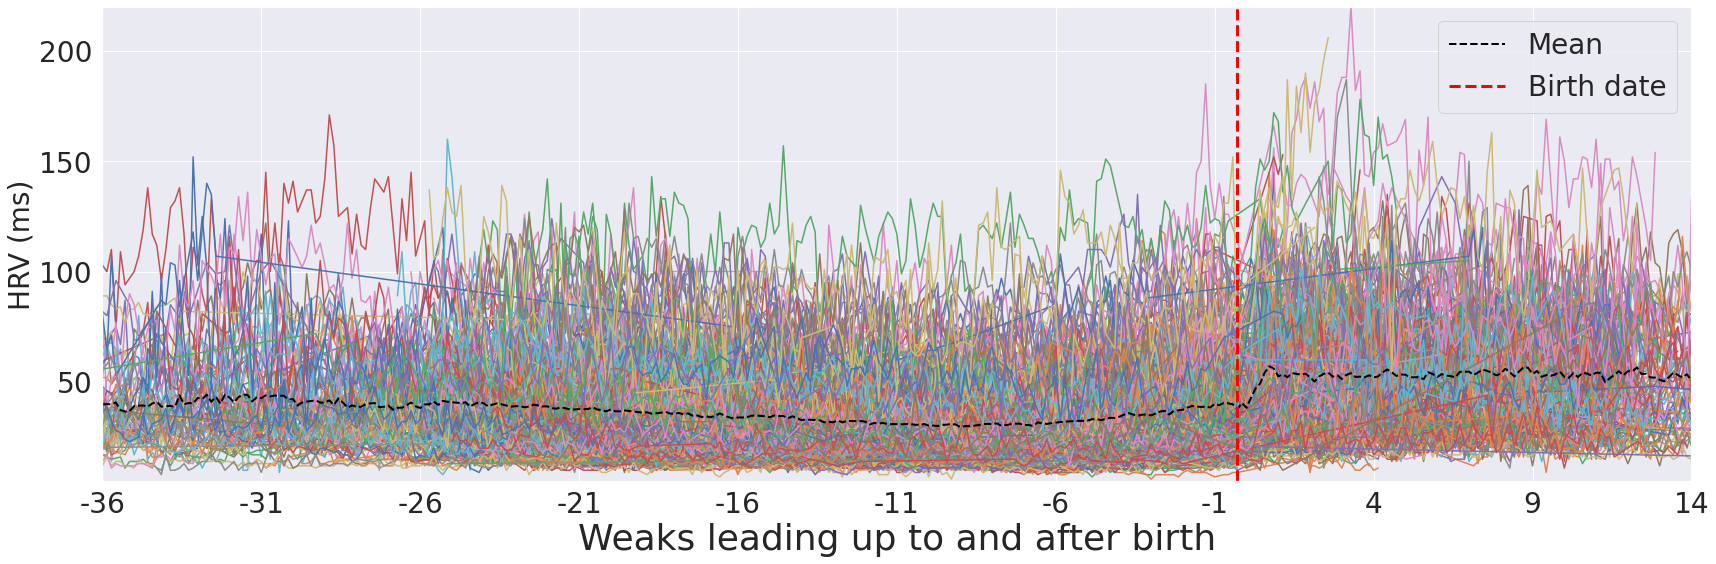

In [5]:
bumpFigSingle(df_sleep, 'rmssd', 'HRV (ms)', 'rmssd', df_sleep.record_id.unique(), df_sleep['rmssd'].min(), df_sleep['rmssd'].max())


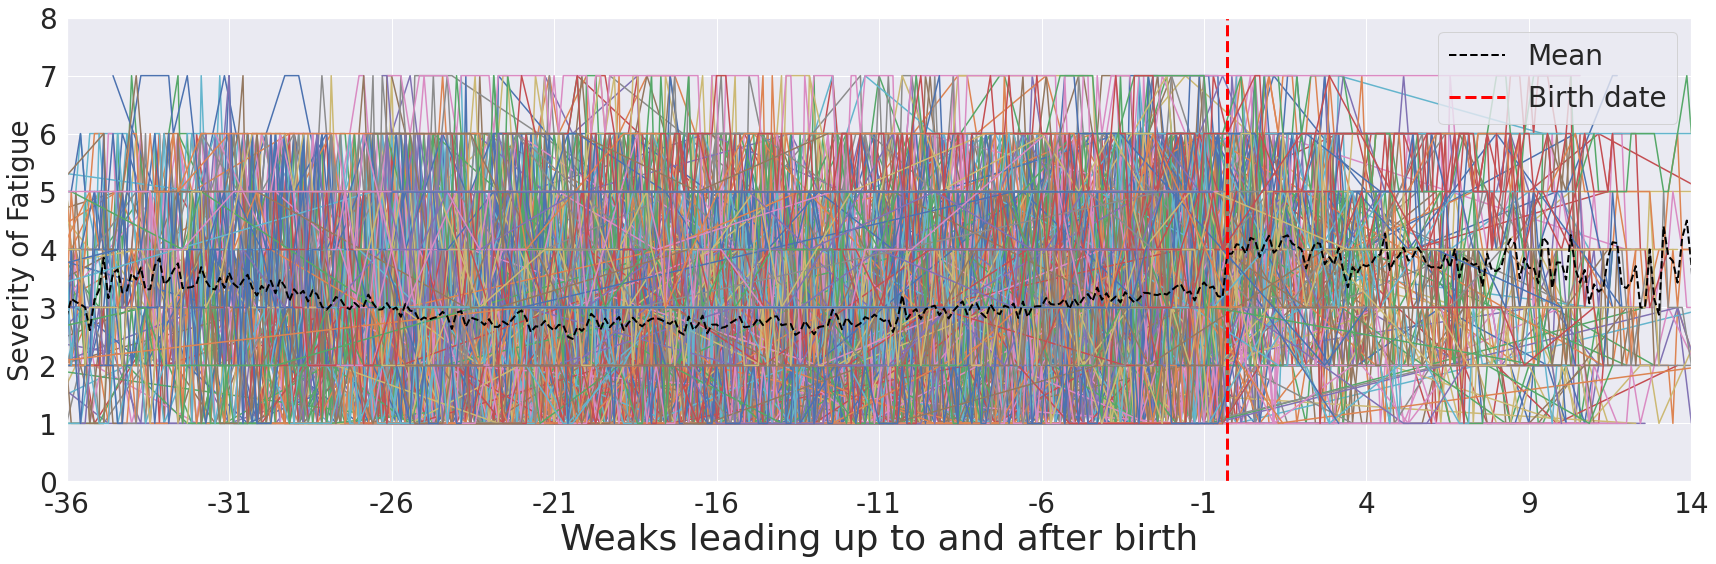

In [19]:
bumpFigSingle(df_fatigue, 'answer_text', 'Severity of Fatigue', 'answer_text', df_fatigue.record_id.unique(), 0, 8)


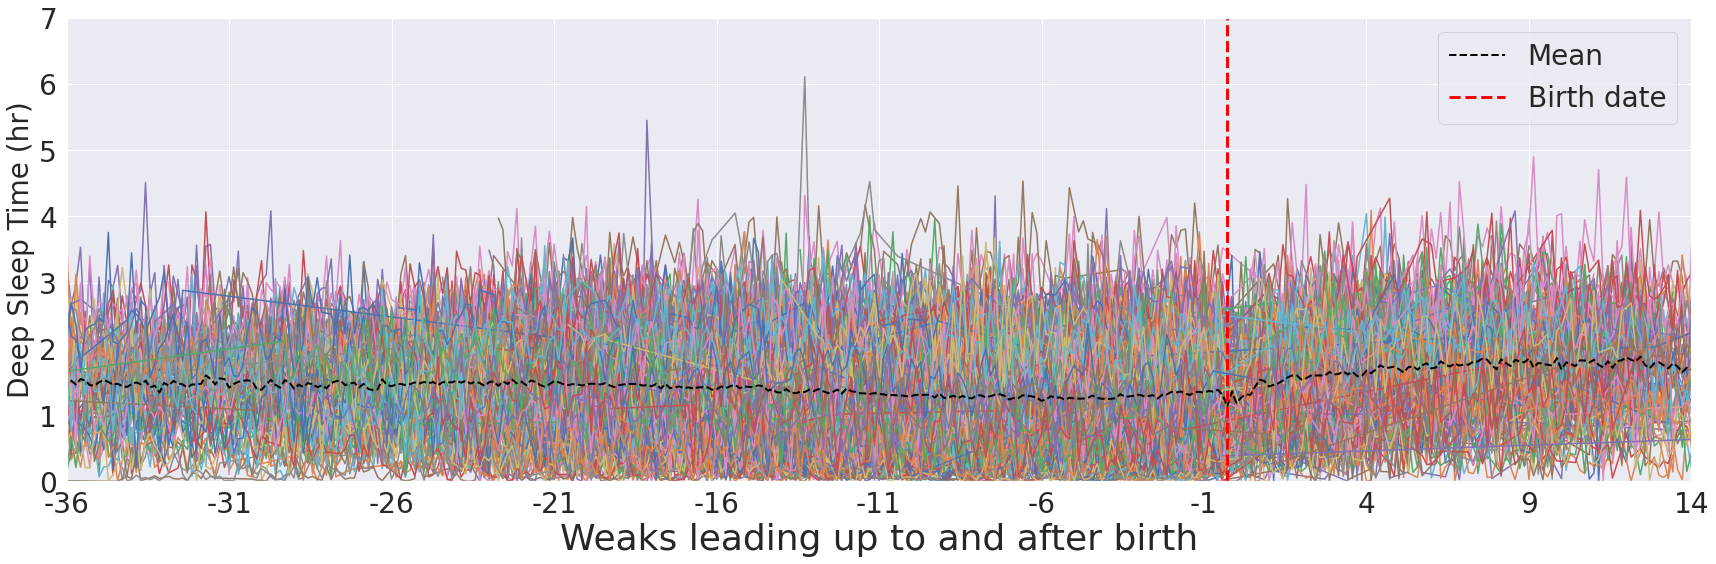

In [7]:
bumpFigSingle(df_sleep, 'deep', 'Deep Sleep Time (hr)', 'deep', df_sleep.record_id.unique(), df_sleep['deep'].min()//3600, 7)


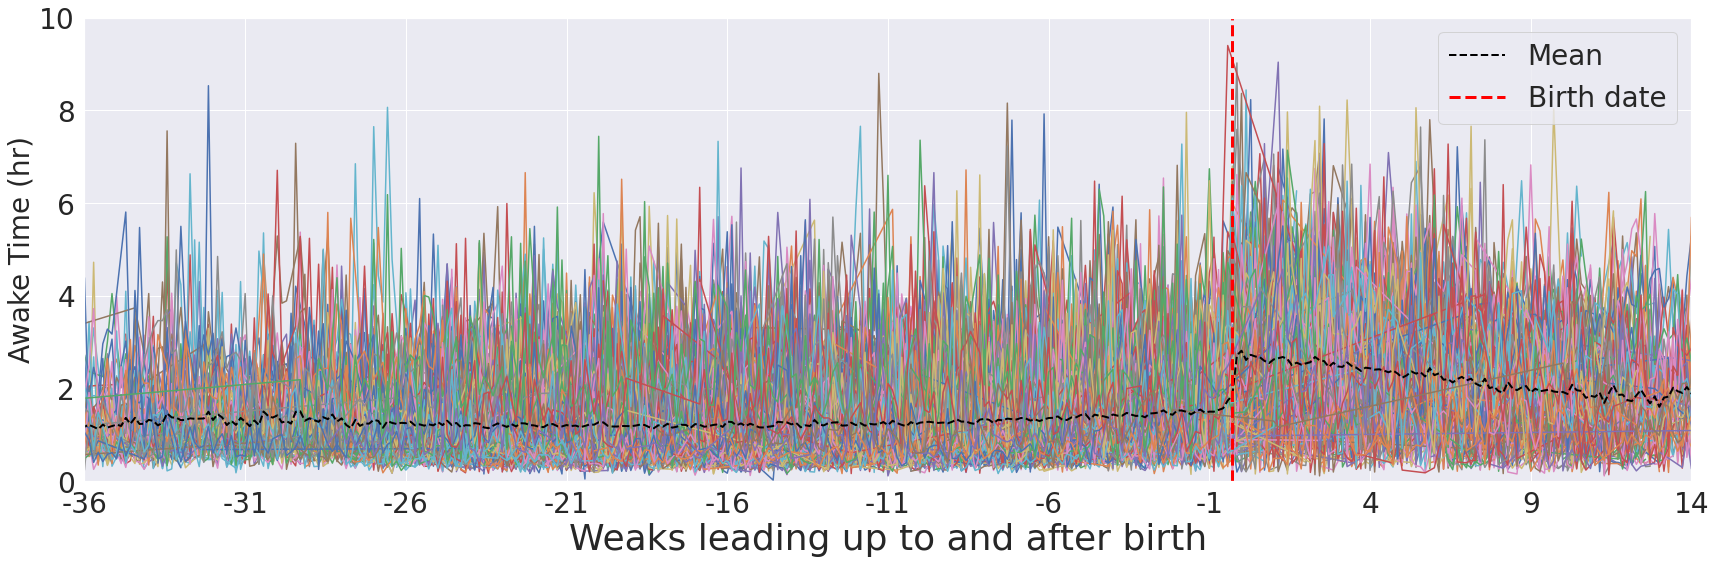

In [8]:
bumpFigSingle(df_sleep, 'awake', 'Awake Time (hr)', 'awake', df_sleep.record_id.unique(), df_sleep['awake'].min()//3600, df_sleep['awake'].max()//3600+1)


## Super healthy population

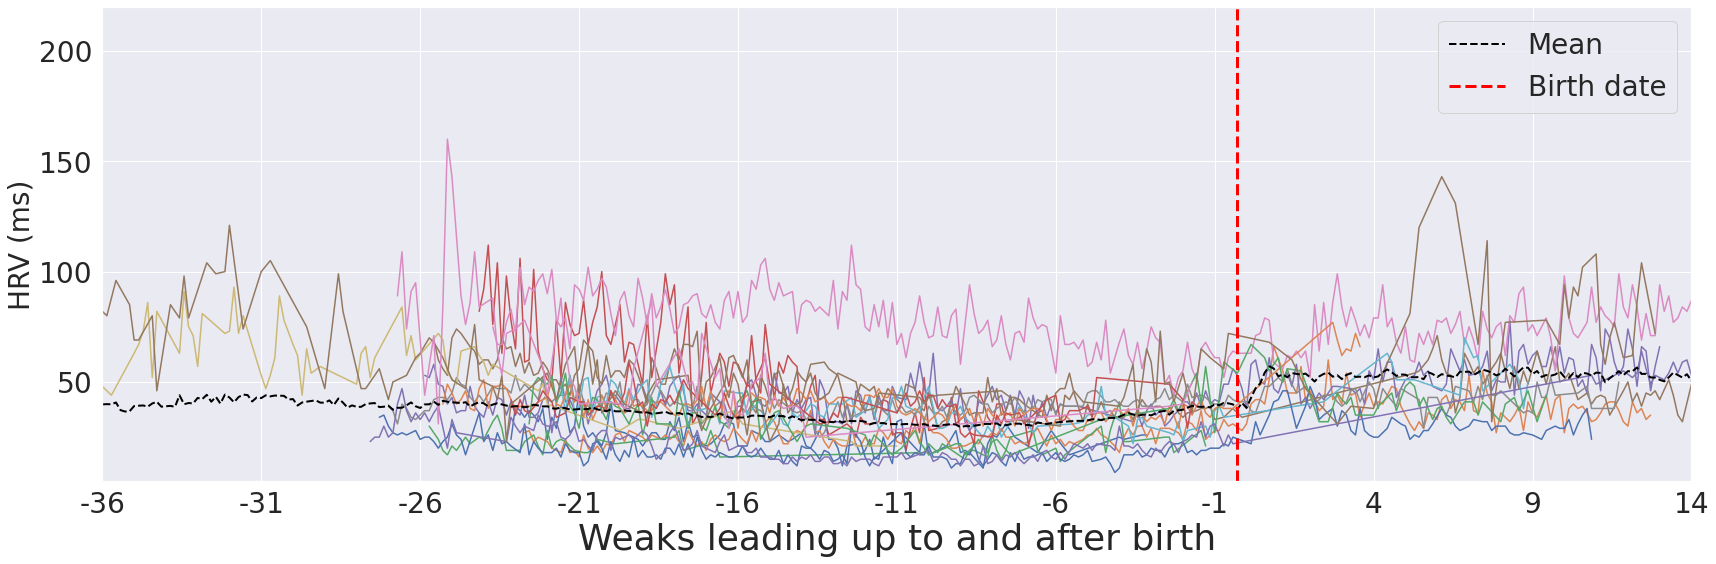

In [25]:
bumpFigSingle(df_sleep, 'rmssd', 'HRV (ms)', 'rmssd', df_sleep.record_id.unique(), df_sleep['rmssd'].min(), df_sleep['rmssd'].max(), group=superHealthy)


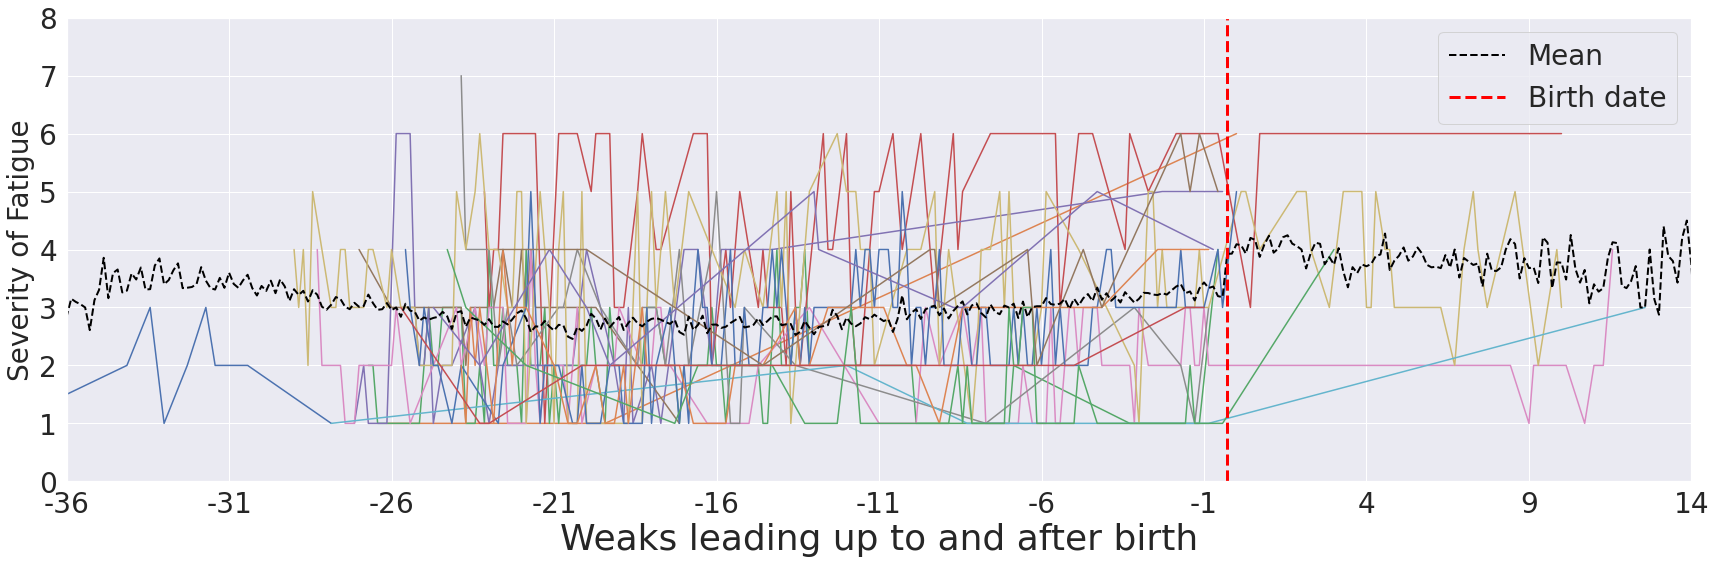

In [10]:
bumpFigSingle(df_fatigue, 'answer_text', 'Severity of Fatigue', 'answer_text', df_fatigue.record_id.unique(), 0, 8, group=superHealthy)


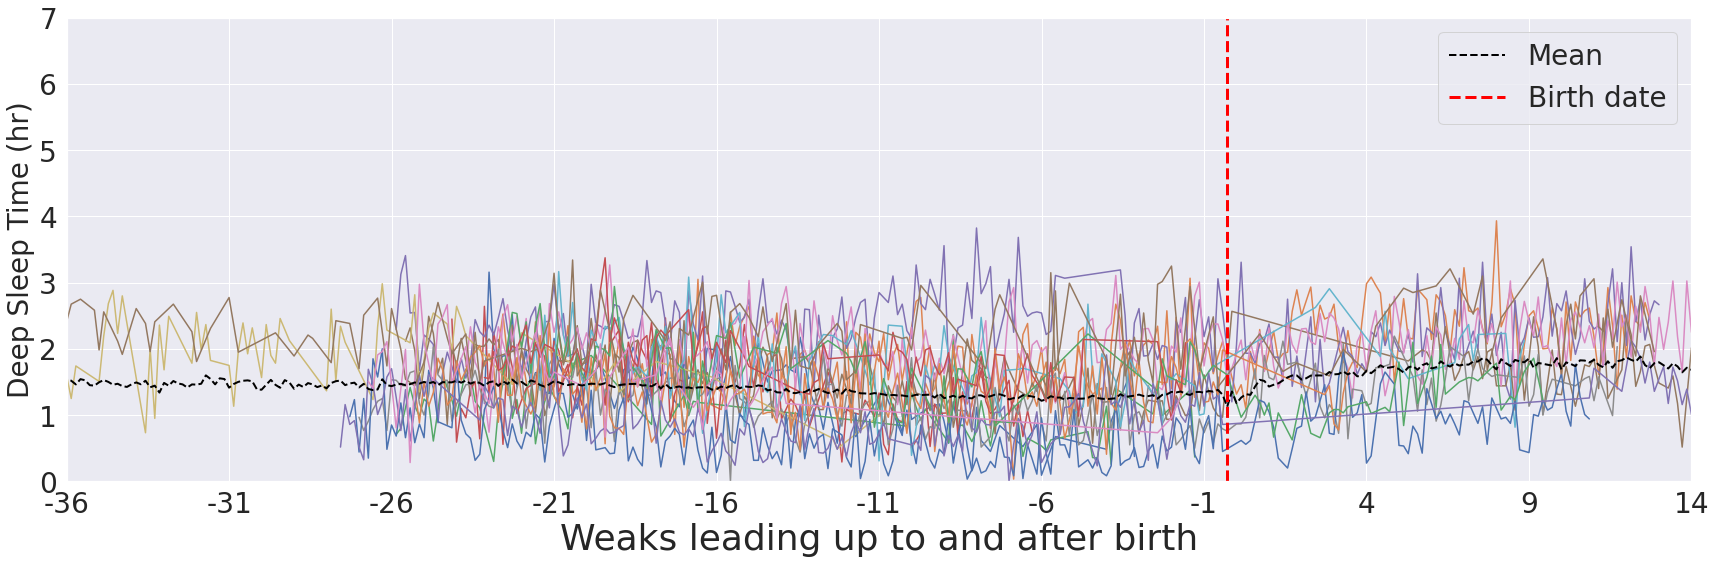

In [11]:
bumpFigSingle(df_sleep, 'deep', 'Deep Sleep Time (hr)', 'deep', df_sleep.record_id.unique(), df_sleep['deep'].min()//3600, 7, group=superHealthy)


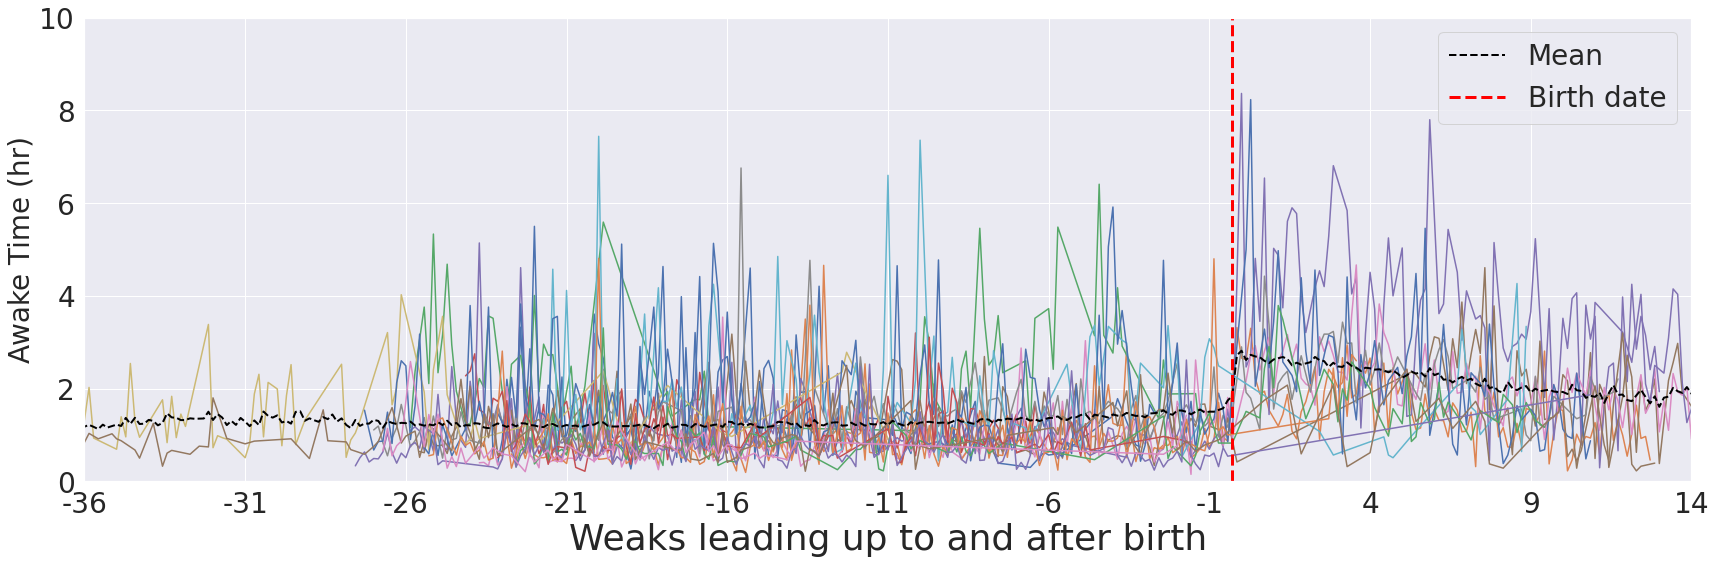

In [12]:
bumpFigSingle(df_sleep, 'awake', 'Awake Time (hr)', 'awake', df_sleep.record_id.unique(), df_sleep['awake'].min()//3600, df_sleep['awake'].max()//3600+1, group=superHealthy)


In [20]:
def getUser(df, user, variable):
    dfUser = df[df.record_id == user]
    dfUser = dfUser.set_index('daysSince')
    dfUser = dfUser.resample('1D')[variable].mean()
    dfUser.name = 'value'
    dfUser = dfUser.reset_index('daysSince')
    dfUser['daysSince'] = (dfUser['daysSince'] / np.timedelta64(1, 'D')).astype(int)
    dfUser['record_id'] = user
    return dfUser
def bumpBoxplotSingle(df1, v1, ylabel, fileName, userList, ymin=None, ymax=None):
    
    fig = plt.figure(figsize=(24,8))
    
    palette = sns.color_palette('muted')

    plt.rcParams.update({'figure.max_open_warning': 0})
    sns.set_theme(style='darkgrid')
    
    df1 = findDaysSince(df1)
    
    totalDF1 = pd.DataFrame(columns = ['daysSince', 'value', 'record_id'])
    
    for user in userList:
        dfUser1 = getUser(df1, user, v1)
        if (len(dfUser1) == 0):
            # print(str(user) + ' missing variable 1')
            continue
        if fileName == "deep" or fileName == "awake":
            dfUser1['value'] = dfUser1['value'] / 3600
        totalDF1 = pd.concat([totalDF1, dfUser1])
        
    totalDF1['weeksSince'] = totalDF1['daysSince'] // 7 
    totalDF1 = totalDF1[(totalDF1['daysSince'] > -250) & (totalDF1['daysSince'] < 100)]
    totalDF1 = totalDF1.dropna()
    totalDF1_week = totalDF1.groupby(['record_id', 'weeksSince'], as_index=False)['value'].mean()
    sns.boxplot(x='weeksSince', y='value', data=totalDF1_week, color='lightblue')

    plt.ylabel(ylabel, fontsize=28)  
    plt.ylim(ymin, ymax)

    plt.xlabel('Weaks leading up to and after birth', fontsize=36) 
    
    # Get current x-ticks and labels
    current_xticks = plt.gca().get_xticks()
    current_xtick_labels = [tick.get_text() for tick in plt.gca().get_xticklabels()]
    
    # Filter ticks and labels
    filtered_xticks = current_xticks[::5]  # Keep every 5th tick
    filtered_xtick_labels = current_xtick_labels[::5]  # Filter labels to match ticks
    
    # Reapply filtered ticks and labels
    plt.xticks(ticks=filtered_xticks, labels=filtered_xtick_labels, fontsize=20)
    
    plt.tick_params(axis='x', labelsize=28)
    plt.tick_params(axis='y', labelsize=28)
    plt.axvline(x=36, color='red', linestyle='--', linewidth=3, label="Birth date")
    plt.legend(loc="upper right", fontsize=28)  # Increase legend font size

    fig.tight_layout()
    fig.show()
    

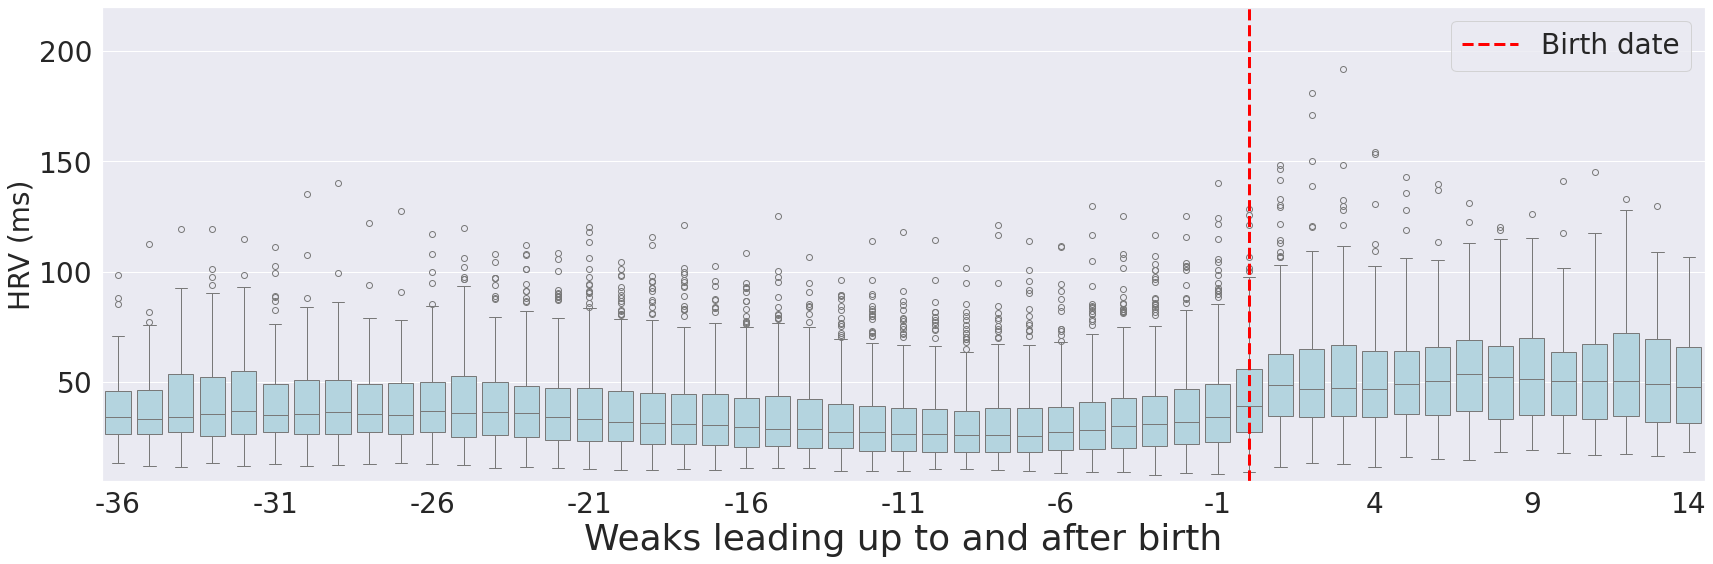

In [14]:
bumpBoxplotSingle(df_sleep, 'rmssd', 'HRV (ms)', 'rmssd', df_sleep.record_id.unique(), df_sleep['rmssd'].min(), df_sleep['rmssd'].max())


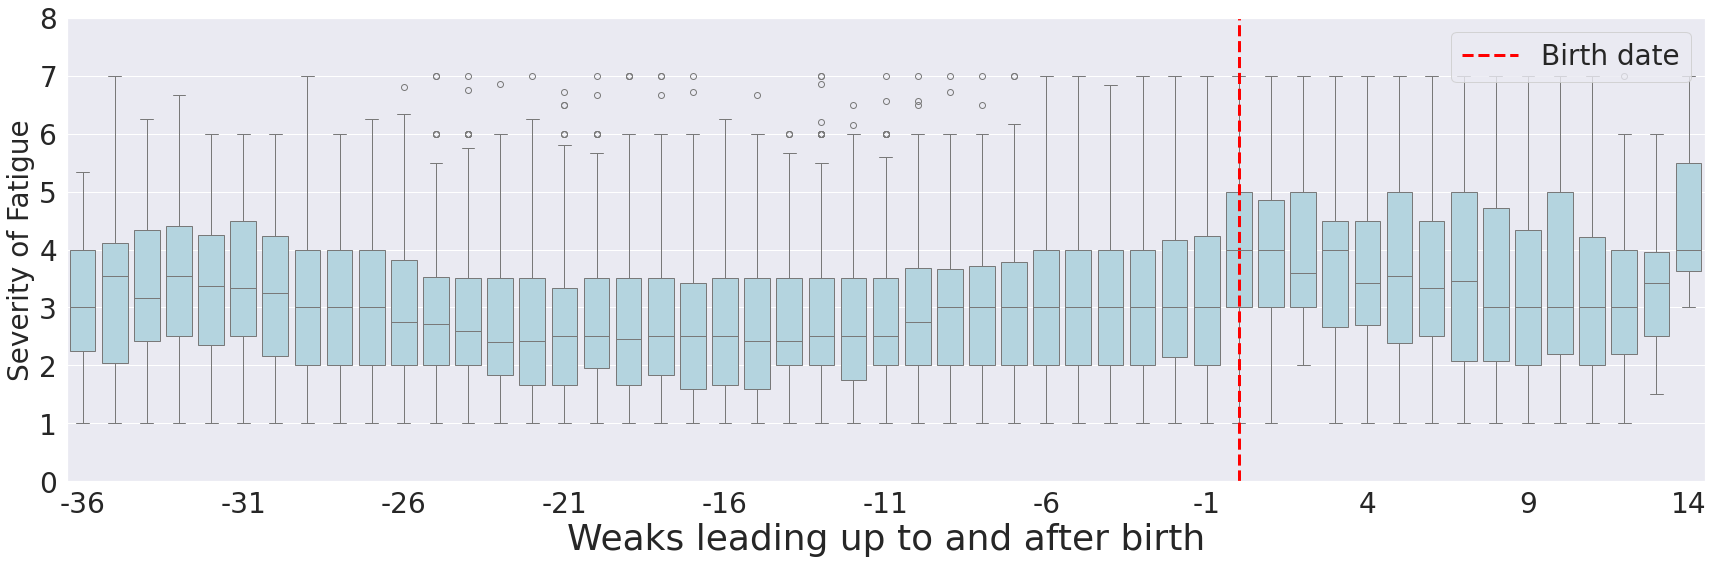

In [21]:
bumpBoxplotSingle(df_fatigue, 'answer_text', 'Severity of Fatigue', 'answer_text', df_fatigue.record_id.unique(), 0, 8)


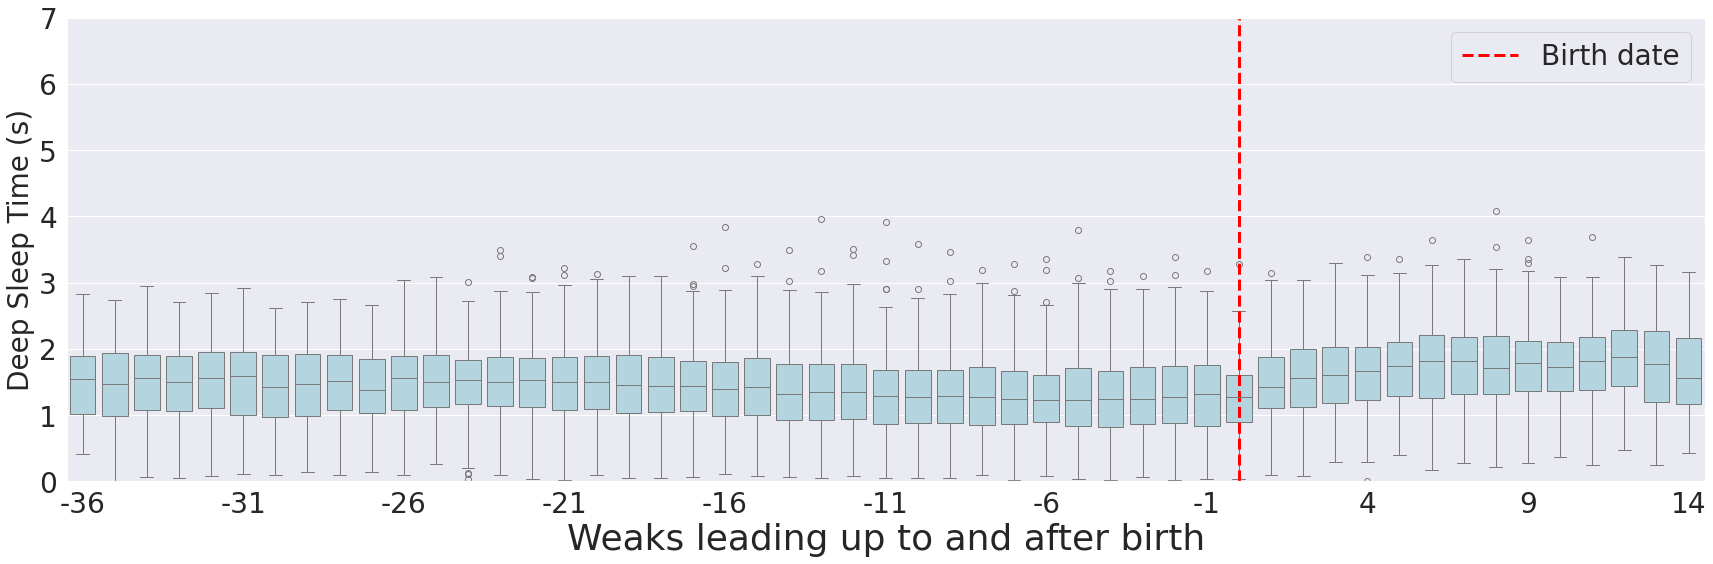

In [16]:
bumpBoxplotSingle(df_sleep, 'deep', 'Deep Sleep Time (s)', 'deep', df_sleep.record_id.unique(), 0, 7)


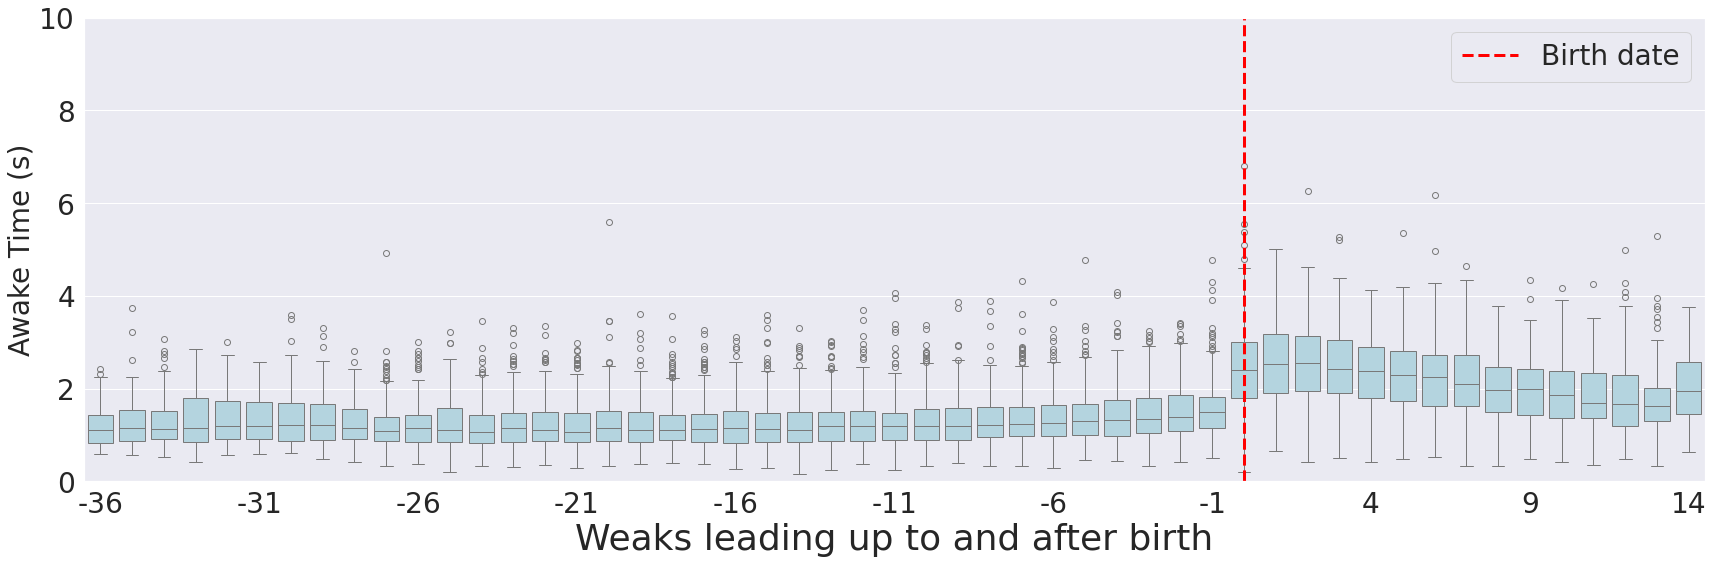

In [17]:
bumpBoxplotSingle(df_sleep, 'awake', 'Awake Time (s)', 'awake', df_sleep.record_id.unique(), 0, 10)
